In [328]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from topostats.io import LoadScans
import topostats.filters as topofilters
from skimage.filters import threshold_otsu
from topostats.utils import get_mask
from skimage.filters import gaussian
from skimage.morphology import remove_small_objects, label
from skimage.measure import regionprops
from skimage import draw
from skimage import util
from topostats.theme import Colormap
import math
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import seaborn as sns 

In [329]:
cmap = Colormap("nanoscope").get_cmap()
def plot(image: np.ndarray, title: str=None, zlimit: bool=True, figsize: tuple=(8, 8), **kwargs) -> None:
    fig, ax = plt.subplots(figsize=figsize)
    if zlimit == True:
        vmin=-3
        vmax=4
    else:
        vmin=None
        vmax=None
    ax.imshow(image, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)
    if title is not None:
        ax.set_title(title)
    plt.show()

[Tue, 12 Dec 2023 14:29:30] [INFO    ] [topostats] Extracting image from M10Zoom\20230207_KM10-007_25mMMgCl2_Vacuum.0_00008.spm
[Tue, 12 Dec 2023 14:29:30] [INFO    ] [topostats] Loading image from : M10Zoom\20230207_KM10-007_25mMMgCl2_Vacuum.0_00008.spm
[Tue, 12 Dec 2023 14:29:30] [INFO    ] [topostats] [20230207_KM10-007_25mMMgCl2_Vacuum.0_00008] : Loaded image from : M10Zoom\20230207_KM10-007_25mMMgCl2_Vacuum.0_00008.spm
[Tue, 12 Dec 2023 14:29:30] [INFO    ] [topostats] [20230207_KM10-007_25mMMgCl2_Vacuum.0_00008] : Extracted channel Height
[Tue, 12 Dec 2023 14:29:30] [INFO    ] [topostats] [20230207_KM10-007_25mMMgCl2_Vacuum.0_00008] : Pixel to nm scaling : 1.98365234375
1.98365234375


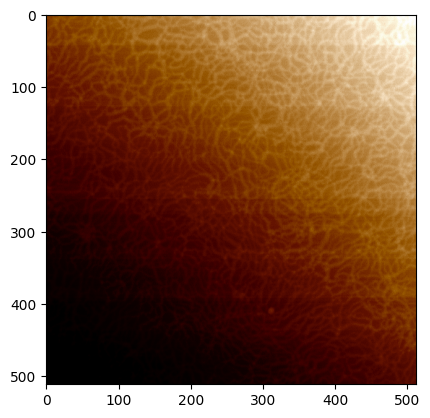

In [381]:
#Import SPM files
#file = Path('./PristineZoom/20221213_KDNA001_MgCl2_H20Sit_Vacuum.0_00022.spm')
#file = Path('./PristineZoom/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm')
#file = Path('./EP_Zoom/20230419_EPN005_Metal.0_00006.spm')
#file = Path('./PristineZoom/Mid/20230417_KPN0018_Metal.0_00005.spm')

#Full image
#file = Path('./flat/20230126_KPN005.0_00013.spm')
#EP Zoom
#file = Path('./EP_Zoom/20230419_EPN005_Metal.0_00004.spm')
#file = Path('./EP_Zoom/20230419_EPN005_Metal.0_00008.spm')
#file = Path('./EP_Zoom/20230419_EPN005_Metal.0_00006.spm')
#file = Path('./EP_Zoom/20230419_EPN005_Metal.0_00009.spm')
#M10 Zoom
#file = Path('./M10Zoom/20230207_KM10-007_25mMMgCl2_Vacuum.0_00006.spm')
file = Path('./M10Zoom/20230207_KM10-007_25mMMgCl2_Vacuum.0_00008.spm')

loadscans = LoadScans([file], 'Height')
loadscans.get_data()
p_to_nm = loadscans.pixel_to_nm_scaling
image_raw = loadscans.image
plt.imshow(image_raw, cmap=cmap)
print(p_to_nm)

In [382]:
filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    row_alignment_quantile=0.05,
    threshold_std_dev={'upper': 1.0, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False}
)

filters.filter_image()

[Tue, 12 Dec 2023 14:29:31] [INFO    ] [topostats] [M10Zoom\20230207_KM10-007_25mMMgCl2_Vacuum.0_00008.spm] : Median flattening without mask
[Tue, 12 Dec 2023 14:29:31] [INFO    ] [topostats] [M10Zoom\20230207_KM10-007_25mMMgCl2_Vacuum.0_00008.spm] : Plane tilt removal without mask
[Tue, 12 Dec 2023 14:29:31] [INFO    ] [topostats] [M10Zoom\20230207_KM10-007_25mMMgCl2_Vacuum.0_00008.spm] : x-polyfit 1st order: [ 0.02027216 -0.69096607]
[Tue, 12 Dec 2023 14:29:31] [INFO    ] [topostats] [M10Zoom\20230207_KM10-007_25mMMgCl2_Vacuum.0_00008.spm] : y-polyfit 1st order: [-1.13888876e-04  4.43653531e+00]
[Tue, 12 Dec 2023 14:29:31] [INFO    ] [topostats] [M10Zoom\20230207_KM10-007_25mMMgCl2_Vacuum.0_00008.spm] : Removing x plane tilt
[Tue, 12 Dec 2023 14:29:31] [INFO    ] [topostats] [M10Zoom\20230207_KM10-007_25mMMgCl2_Vacuum.0_00008.spm] : removing y plane tilt
[Tue, 12 Dec 2023 14:29:31] [INFO    ] [topostats] [M10Zoom\20230207_KM10-007_25mMMgCl2_Vacuum.0_00008.spm] : Remove quadratic bow 

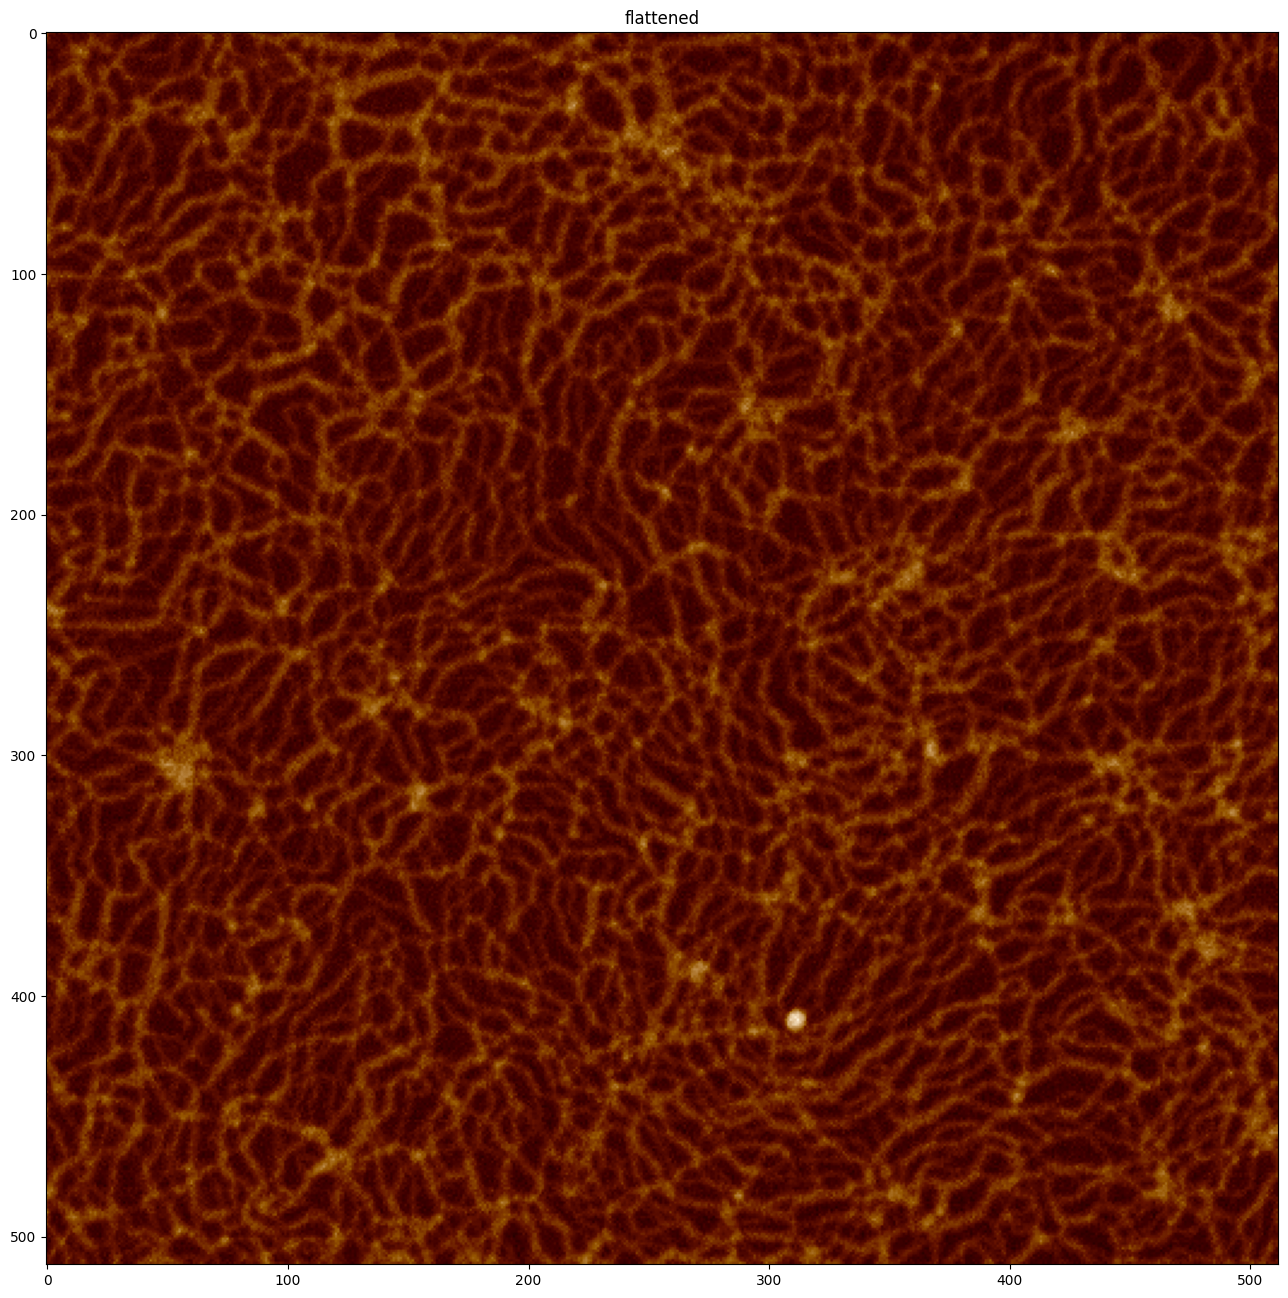

In [383]:
flattened = filters.images['zero_average_background']
plot(flattened, title='flattened',figsize=(16,16))

thresholds: defaultdict(None, {'upper': 0.10838225390236933})
[Tue, 12 Dec 2023 14:29:34] [INFO    ] [topostats] [None] : Masking (upper) Threshold: 0.10838225390236933


C:\Users\bdigg\AppData\Local\Temp\ipykernel_26388\2575541600.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  otsu_threshold_multiplier=np.float(0.6)


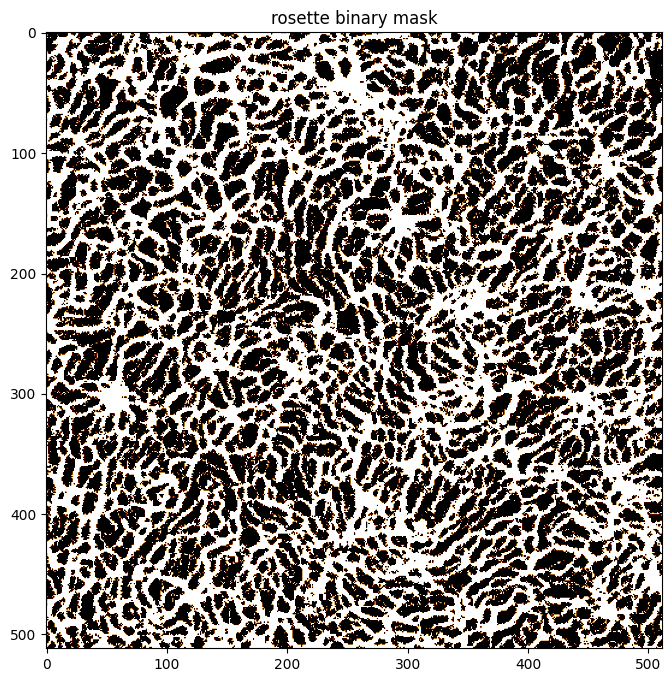

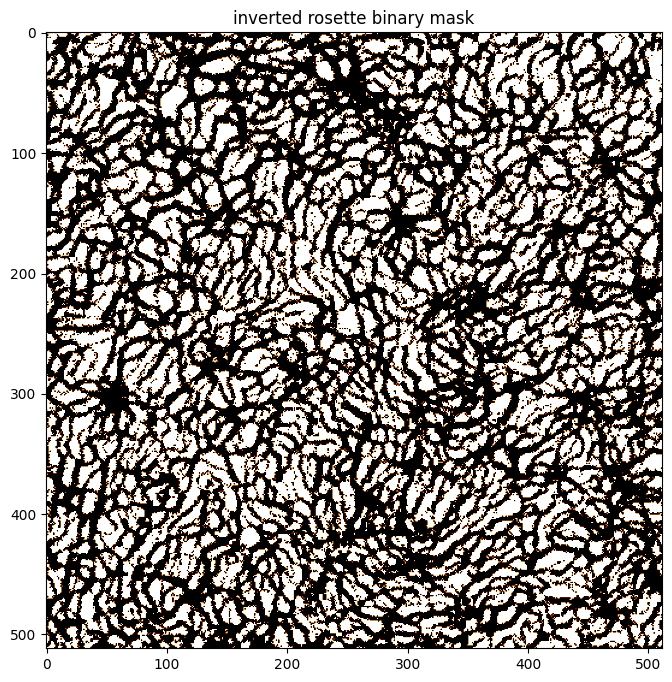

In [384]:
#Threshold

strand_thresholds = topofilters.get_thresholds(
    flattened,
    threshold_method='otsu',
    otsu_threshold_multiplier=np.float(0.6)
    #0.7 for zooms
    )

print(f'thresholds: {strand_thresholds}')
strand_mask = topofilters.get_mask(image=flattened, thresholds=strand_thresholds)
plot(strand_mask.astype(bool), title='rosette binary mask', zlimit=False)
grain_mask = util.invert(strand_mask)
plot(grain_mask.astype(bool), title='inverted rosette binary mask', zlimit=False)



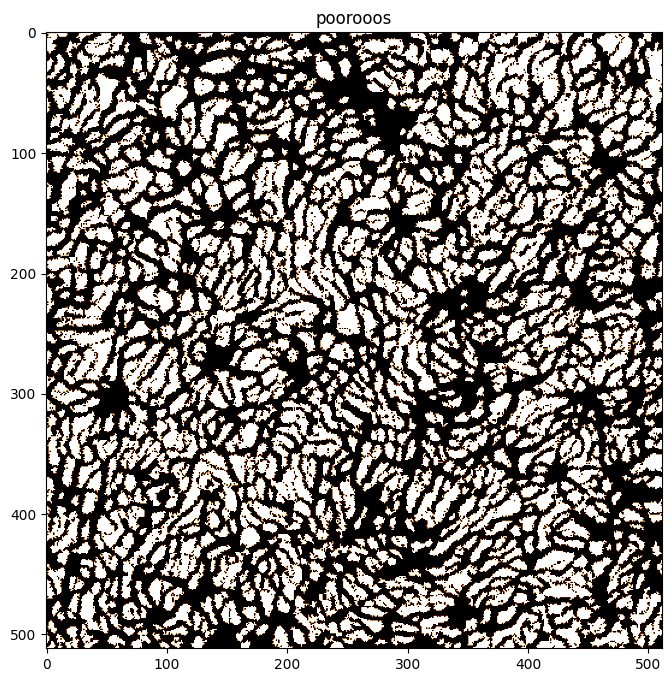

In [385]:
# Remove small objects (smaller than strand squared)
removed_small_objects = remove_small_objects(grain_mask, (36/p_to_nm))
# Remove large objects
labelled_grain_mask = label(removed_small_objects)
regions = regionprops(labelled_grain_mask)
for props_index, props in enumerate(regions):
    if props.area > 50000: #100000 for zooms
        labelled_grain_mask[labelled_grain_mask==props.label] = 0
plot(labelled_grain_mask.astype(bool), title='poorooos', zlimit=False)


In [386]:
region_props = regionprops(labelled_grain_mask)
areas = np.zeros(len(region_props))

for props_index, props in enumerate(region_props):
        areas[props_index] = props.area
areas_nm = areas*(p_to_nm**2)
diameter_nm = np.sqrt(areas_nm)
print("Mean Pore Area: ","%.2f" % np.mean(areas_nm))
print("Median Pore Area: ","%.2f" % np.median(areas_nm))
print("Mean Pore Diameter: ","%.2f" % np.mean(diameter_nm))
print("Median Pore Diameter: ","%.2f" % np.median(diameter_nm))
print("Standard Deviation Pore Diameter:","%.2f" % np.std(diameter_nm))


Mean Pore Area:  823.57
Median Pore Area:  362.01
Mean Pore Diameter:  23.67
Median Pore Diameter:  19.03
Standard Deviation Pore Diameter: 16.22


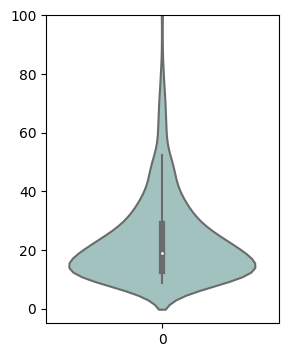

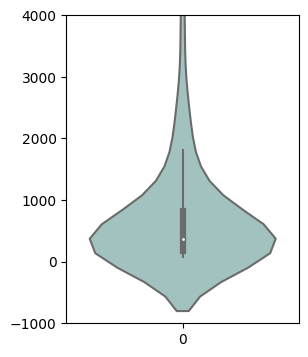

In [387]:
fig, ax = plt.subplots(figsize=(3,4))
sns.violinplot(diameter_nm, color=[138/225,176/225,174/225,1/225])
ax.set_ylim(-5,100)
plt.show()
fig, ax = plt.subplots(figsize=(3,4))
sns.violinplot(areas_nm, color=[138/225,176/225,174/225,1/225])
ax.set_ylim(-1000,4000)
plt.show()

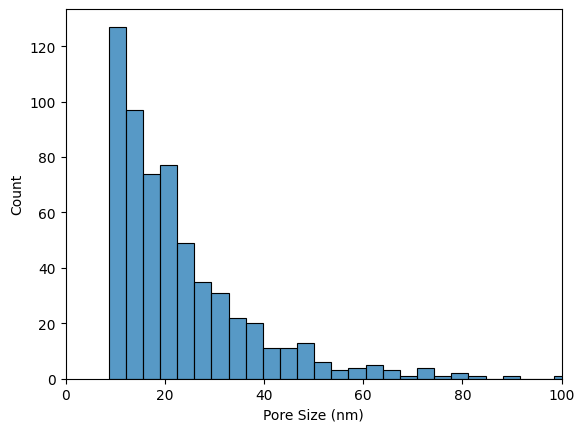

In [388]:
fig, ax = plt.subplots()
sns.histplot(diameter_nm, bins=40)
ax.set_xlim(0,100)
plt.xlabel('Pore Size (nm)')
plt.show()

In [389]:

# Remove small objects
removed_small_objects = remove_small_objects(grains, 1)
# Remove large objects
labelled_grain_mask = label(removed_small_objects)
regions = regionprops(labelled_grain_mask)
for props_index, props in enumerate(regions):
    if props.area > 25:
        labelled_grain_mask[labelled_grain_mask==props.label] = 0